In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm 
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('../data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [5]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [29]:
id_to_category = dict(zip(categories['id'], categories['category']))


dict_items([(0, 'sports'), (1, 'inactivity quiet/light'), (2, 'miscellaneous'), (3, 'occupation'), (4, 'water activities'), (5, 'home activities'), (6, 'lawn and garden'), (7, 'religious activities'), (8, 'winter activities'), (9, 'conditioning exercise'), (10, 'bicycling'), (11, 'fishing and hunting'), (12, 'dancing'), (13, 'walking'), (14, 'running'), (15, 'self care'), (16, 'home repair'), (17, 'volunteer activities'), (18, 'music playing'), (19, 'transportation')])

In [7]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (img_train).
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.files = os.listdir(self.img_dir)
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.files[idx]
        img_id =img_id.split('.')[0]
        # img_id1 = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        # label = self.labels.iloc[idx, 1]  # target_feature (метка)
        label = self.labels.loc[self.labels['img_id'] == int(img_id), 'target_feature'].values[0]

        # Загружаем изображение
        # img_path = os.path.join(self.img_dir, 'aug_'+str(img_id)+'.jpg')
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label, img_id
    
    def __len__(self):
        return len(self.files)


# Создание папки с аугментированными изображениями и ответами к ним

Перед аугментацией, разобъем наш датасет на две части

In [9]:
#Класс для разделения
class SplitPFileToVal:
    def __init__(self, path_to_dir, path_to_new_dir_val, path_to_new_dir_train, p:float):
        """
        Создаёт 2 новые папки: Для валидации - % от всех изображений, для трейна - все остальное. 
        Нужно для отделения части датасета, для val данных

        path_to_dir: Папка с изображениями. (img_train)
        path_to_new_dir_val: Путь до новой папки, можно не создавать вручную.
        path_to_new_dir_train: Путь до новой папки, можно не создавать вручную.
        p: % изображений, которые будут отделены для валидационного датасета
        """

        #Проверка, введеного %
        if not isinstance(p, float):
            raise TypeError("% должен быть float")
        if p <= 0 or p > 1:
            raise ValueError("% должен быть в диапозоне: 0 < p <= 1")
        self.p = p

        self.path_to_dir = path_to_dir
        self.files = os.listdir(self.path_to_dir)
        self.path_to_new_dir_val = path_to_new_dir_val
        self.path_to_new_dir_train = path_to_new_dir_train



        # Создаем папки для сохранения
        if os.path.exists(path_to_new_dir_val):
            shutil.rmtree(path_to_new_dir_val)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_val, exist_ok=True)

        if os.path.exists(path_to_new_dir_train):
            shutil.rmtree(path_to_new_dir_train)  # Удаляем папку, если она уже существует
        os.makedirs(path_to_new_dir_train, exist_ok=True)

    def split(self):
        len_val = int(len(self.files)*self.p)
        len_train = len(self.files) - len_val
        with tqdm(total=len_val, desc="Отделение валидационных данных", unit="img") as pbar:
            for _ in range(len_val):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_val+f'/{file}')
                self.files.pop(idx)

                pbar.update(1)

        with tqdm(total=len_train, desc="Отделение тренировочных данных", unit="img") as pbar:
            for _ in range(len_train):
                idx = random.randint(0, len(self.files) - 1)
                file = self.files[idx]
                path_to_file = self.path_to_dir+f'/{file}'
                shutil.copy(path_to_file, self.path_to_new_dir_train+f'/{file}')
                self.files.pop(idx)
                
                pbar.update(1)

        print(f"\nОтделено {len_val} изображений, для валидации в папку: {self.path_to_new_dir_val}")
        print(f"Отделено {len_train} изображений, для тренировки в папку: {self.path_to_new_dir_train}")



In [10]:
#Использование разделения
spliter = SplitPFileToVal(
    path_to_dir='../data/img_train',
    path_to_new_dir_val='../data/val_dataset',
    path_to_new_dir_train='../data/train_dataset',
    p=0.1
)

spliter.split()

Отделение тренировочных данных: 100%|██████████| 11131/11131 [00:34<00:00, 319.18img/s]


Отделено 1236 изображений, для валидации в папку: ../data/val_dataset
Отделено 11131 изображений, для тренировки в папку: ../data/train_dataset


In [11]:
#Класс для создания аугментаций
class AugmentedDatasetSaver:
    def __init__(self, original_train_dataset, csv_path, augmentation_transform, new_train_dataset_path, output_csv_path, augment_count):
        """
        Создает и сохраняет аугментированный датасет из тренировочного.
        Также создает csv с ответами на аугментированный датасет, сохраняет ответы из train_answers

        original_train_dataset: Исходный датасет (torch Dataset).
        csv_path: путь к csv с ответами
        augmentation_transform: Трансформации для аугментации.
        new_train_dataset_path: Папка, куда будут сохранены данные.
        output_csv_path: Путь, куда будет сохранена csv
        augment_count: Количество аугментированных изображений, которые нужно создать.
        """
        self.original_train_dataset_path = original_train_dataset
        self.augmentation_transform = augmentation_transform
        self.new_train_dataset_path = new_train_dataset_path
        self.output_csv_path = output_csv_path
        self.original_labels = pd.read_csv(csv_path)

        
        if augment_count >= len(original_train_dataset):
            print("Введеный augment_count > длины датасета")
        self.augment_count = augment_count


        # Создаем папку для сохранения
        if os.path.exists(new_train_dataset_path):
            shutil.rmtree(new_train_dataset_path)  # Удаляем папку, если она уже существует
        os.makedirs(new_train_dataset_path, exist_ok=True)

    def save(self):
        new_entries = []
        max_id = self.original_labels['img_id'].max()
        with tqdm(total=self.augment_count, desc="Создание аугментированных данных", unit="img") as pbar:
            for i in range(self.augment_count):
                # Выбираем случайное изображение из оригинального датасета
                image, label, img_id = random.choice(self.original_train_dataset_path)

                # Преобразуем в тензор, если это PIL.Image
                if not isinstance(image, Image.Image):
                    raise ValueError(f"Unsupported image format: {type(image)}")

                # Применяем аугментацию
                augmented_image = self.augmentation_transform(image)

                

                # Генерируем имя файла, сохраняя оригинальное имя с префиксом
                img_id = max_id+i+1

                new_entries.append({'img_id': int(img_id), 'target_feature': label})

                img_save_path = os.path.join(self.new_train_dataset_path, f"{img_id}.jpg")

                # Преобразуем аугментированный тензор обратно в PIL.Image и сохраняем
                augmented_image = transforms.ToPILImage()(augmented_image)  # Перевод тензора в PIL
                augmented_image.save(img_save_path)

                pbar.update(1)
        # Создание DataFrame для новых данных
        augmented_df = pd.DataFrame(new_entries)
        combined_df = pd.concat([self.original_labels, augmented_df], ignore_index=True)
        combined_df.to_csv(self.output_csv_path, index=False)
        
        print(f"CSV файл с метками успешно сохранён в: {self.output_csv_path}")
        print(f"\nСохранено {self.augment_count} аугментированных изображений в папке: {self.new_train_dataset_path}")


In [12]:
#transform для аугментации
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=25), 
    transforms.ToTensor(),  # Преобразование в тензор для работы с RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3))
])

In [13]:
# Загружаем датасет, для тренировки
original_traint_dataset = HumanPoseDataset(
    img_dir='../data/train_dataset',
    csv_file='../data/train_answers.csv',
    transform=None  # Оставляем без изменений
)

# Папка для сохранения аугментированного датасета
save_dir = "../data/augmented_only_dataset"

# Количество аугментированных изображений
augment_count = 11000 

# Создаем и сохраняем 
dataset_saver = AugmentedDatasetSaver(
    original_train_dataset=original_traint_dataset,
    augmentation_transform=augmentation_transform,
    csv_path='../data/train_answers.csv',
    new_train_dataset_path=save_dir,
    augment_count=augment_count,
    output_csv_path='../data/augmented_train_answers.csv'
)

In [14]:
# Создание аугментированных файлов
dataset_saver.save()

Создание аугментированных данных: 100%|██████████| 11000/11000 [04:16<00:00, 42.96img/s]

CSV файл с метками успешно сохранён в: ../data/augmented_train_answers.csv

Сохранено 11000 аугментированных изображений в папке: ../data/augmented_only_dataset


Проверка, что все создалось в нужном кол-ве

In [15]:
line_count = sum(1 for line in open('../data/augmented_train_answers.csv')) - sum(1 for line in open('../data/train_answers.csv'))
if augment_count == line_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {line_count}(line_count)')

OK


In [16]:
aug_file_count = len(os.listdir("../data/augmented_only_dataset"))
if augment_count == aug_file_count:
    print('OK')
else:
    print(f'Ожидалось {augment_count}(augment_count)\n Получилось {aug_file_count}(aug_file_count)')

OK


## Cоединение папки с аугментированными картинками и тренировочным датасетом в новую папку.

Удаляет папку по пути, который указан в path_augmented_only_dataset

In [17]:
def merge_folders(path_train_dataset, path_augmented_only_dataset, path_destination_folder):
    """
    Объединяет две папки с картинками в одну. УДАЛЯЕТ папку path_augmented_only_dataset

    :param path_train_dataset: Путь к первой исходной папке
    :param source_folder2: Путь ко второй исходной папке
    :param destination_folder: Путь к папке назначения
    """
    # Создаем папку назначения, если она не существует
    if os.path.exists(path_destination_folder):
        shutil.rmtree(path_destination_folder)  # Удаляем папку, если она уже существует
    os.makedirs(path_destination_folder, exist_ok=True)
    
    # Функция для копирования файлов из папки
    def copy_files_from_folder(folder):
        with tqdm(total=len(os.listdir(folder)), desc=f"Копирование из {folder}", unit="img") as pbar:
            for file_name in os.listdir(folder):
                source_path = os.path.join(folder, file_name)
                dest_path = os.path.join(path_destination_folder, file_name)
                
                # Проверяем, является ли элемент файлом
                if os.path.isfile(source_path):
                    if os.path.exists(dest_path):
                        raise KeyError('файл с таким именем уже существует в папке назначения')
                    shutil.copy2(source_path, dest_path)
                pbar.update(1)
    
    # Копируем файлы из обеих папок
    copy_files_from_folder(path_train_dataset)
    copy_files_from_folder(path_augmented_only_dataset)
    #Удаляем папку с аугментацией
    shutil.rmtree(path_augmented_only_dataset)

In [18]:
path_train_dataset = '../data/train_dataset'
path_augmented_only_dataset = "../data/augmented_only_dataset"
destination_folder = "../data/augmented_and_train_dataset"

In [19]:
merge_folders(path_train_dataset, path_augmented_only_dataset, destination_folder)

Копирование из ../data/augmented_only_dataset: 100%|██████████| 11000/11000 [00:02<00:00, 3990.32img/s]


In [20]:
expected_count = aug_file_count+len(os.listdir("../data/train_dataset"))
quantity_count = len(os.listdir("../data/augmented_and_train_dataset"))
if expected_count == quantity_count:
    print('OK')
else:
    print(f'Ожидалось {expected_count}(expected_count)\n Получилось {quantity_count}(quantity_count)')

OK


По итогу получилось:   
папка img_train -- картинки в оригинале,  
папка train_dataset -- часть датасета, для обучения,  
папка val_dataset -- часть датасета, для валидации,   
папка augmented_and_train_dataset -- augmented_only_dataset+img_train,   
augmented_train_answers.csv -- ответы на все папки  

# Начало работы с моделью

In [ ]:
# RANDOM_SEED = 52
# generator = torch.Generator().manual_seed(RANDOM_SEED)

In [8]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


In [9]:
# transform_train = transforms.Compose([
#     transforms.Resize((227, 227)), # тк в ауг датасете есть фото без аугментации
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [10]:
val_dataset = HumanPoseDataset(
    img_dir='../data/val_dataset',
    csv_file='../data/train_answers.csv',
    transform=transform
)

train_dataset = HumanPoseDataset(
    img_dir='../data/augmented_and_train_dataset',
    csv_file='../data/augmented_train_answers.csv',
    transform=transform
)



# train_dataset, _ = random_split(dataset_train, [int(0.9*len(dataset_train)), len(dataset_train) - int(0.9*len(dataset_train))], generator)
# _, val_dataset = random_split(dataset_val, [int(0.9*len(dataset_val)), len(dataset_val) - int(0.9*len(dataset_val))], generator)

In [31]:
train_dataset[0]

(tensor([[[ 2.0434,  1.1872,  0.0398,  ...,  2.1804,  2.1462,  1.7694],
          [ 1.8893,  1.5639,  0.2967,  ...,  2.1462,  1.9920,  1.5639],
          [ 2.0263,  1.8893,  0.8276,  ...,  1.3755,  1.4269,  1.1015],
          ...,
          [ 1.2214,  1.2899,  1.3584,  ...,  0.5364,  0.4679,  0.4166],
          [ 1.2557,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823],
          [ 1.2899,  1.3413,  1.3584,  ...,  0.5193,  0.4337,  0.3823]],
 
         [[ 0.6954,  0.1702, -0.5476,  ...,  2.3761,  2.3936,  2.1310],
          [ 0.5203,  0.4678, -0.3025,  ...,  2.3936,  2.3410,  2.0434],
          [ 0.6254,  0.6779,  0.0826,  ...,  1.6933,  1.8683,  1.6583],
          ...,
          [ 0.3978,  0.4678,  0.5028,  ...,  0.0651, -0.0399, -0.0924],
          [ 0.4328,  0.5028,  0.5378,  ...,  0.0126, -0.0749, -0.1275],
          [ 0.4678,  0.5203,  0.5553,  ...,  0.0126, -0.0749, -0.1275]],
 
         [[-0.3578, -0.5844, -0.6715,  ...,  2.6226,  2.6226,  2.5180],
          [-0.4798, -0.4101,

In [9]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label, img_id= dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7351656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping in

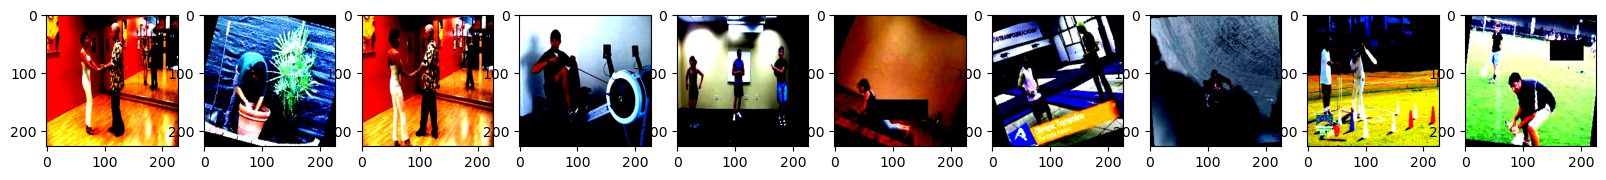

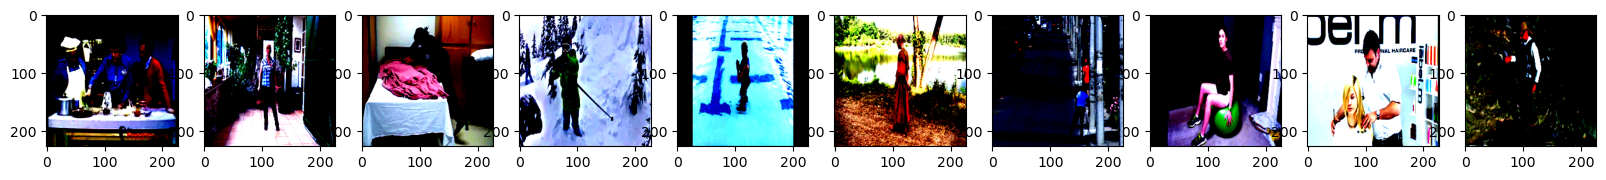

In [11]:
# Получить батч данных
# dataiter = iter(train_loader)
# images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category, 10)
show_images_with_labels(val_dataset, id_to_category, 10)

# Просмотр результатов обучения

In [11]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

<Axes: >

<Figure size 640x480 with 0 Axes>

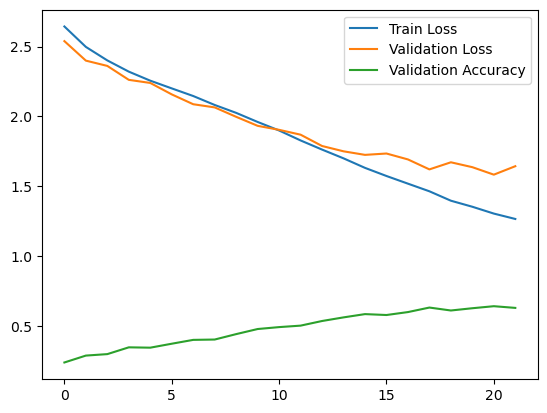

In [31]:
metrics_path = "./train_info/logs_13_12_21_19/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

<Axes: >

<Figure size 640x480 with 0 Axes>

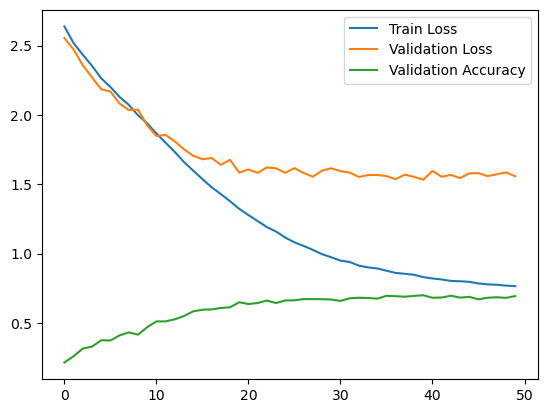

In [13]:
metrics_path = "./train_info/logs_11_12_7_1_custom_resnet18_dp=05/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

<Axes: >

<Figure size 640x480 with 0 Axes>

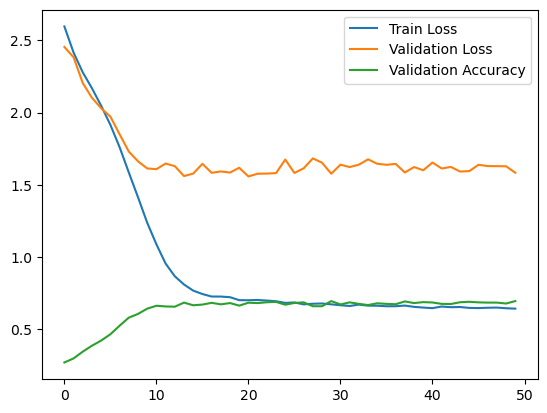

In [14]:

metrics_path = "./train_info/logs_11_12_2_56_custom_resnet18_m_dp=0.2/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

# Построение ансабля

Модели придварительно обученны в других ноутбуках. Загружаю модели (И веса и архитектуру)

In [12]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(nn.functional.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.3):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.3):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18(num_classes=20, dropout_prob=0.3):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)


In [13]:
model_res = custom_resnet18(dropout_prob=0.5).to(device)

In [14]:
path_res_check = './train_info/checkpoints_14_12_17_44/best_UpdatedResNet_checkpoint_22_val_accuracy=0.6505.pt'

In [15]:
checkpoint = torch.load(path_res_check, map_location=torch.device(device))
model_res.load_state_dict(checkpoint["model"])

/tmp/ipykernel_24218/564364420.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_res_check, map_location=torch.device(device))


<All keys matched successfully>

In [16]:
import torch.nn.functional as F
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.fc(y)
        return x * y

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.2):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mish = Mish()
        self.group_norm1 = nn.GroupNorm(32, out_channels)
        self.dropout1 = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.group_norm2 = nn.GroupNorm(32, out_channels)
        self.dropout2 = nn.Dropout2d(p=dropout_prob)

        self.se_block = SEBlock(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.mish(out)
        out = self.group_norm1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.mish(out)
        out = self.group_norm2(out)
        out = self.dropout2(out)

        out = self.se_block(out)
        out += identity
        out = self.mish(out)
        return out

class UpdatedResNet(nn.Module):
    def __init__(self, block, layers, num_classes=20, dropout_prob=0.2):
        super(UpdatedResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.mish = Mish()
        self.group_norm = nn.GroupNorm(32, 64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], dropout_prob=dropout_prob)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.2):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(32, out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, dropout_prob=dropout_prob))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels, dropout_prob=dropout_prob))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.mish(x)
        x = self.group_norm(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def custom_resnet18_m(num_classes=20, dropout_prob=0.2):
    return UpdatedResNet(ResidualBlock, [2, 2, 2, 2], num_classes, dropout_prob)

In [17]:
model_res_m = custom_resnet18_m(dropout_prob=0.2).to(device)

In [20]:
path_res_m_check = './train_info/checkpoints_14_12_18_21/best_UpdatedResNet_checkpoint_13_val_accuracy=0.6448.pt'


In [21]:
checkpoint = torch.load(path_res_m_check, map_location=torch.device(device))
model_res_m.load_state_dict(checkpoint["model"])

/tmp/ipykernel_24218/1621347455.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_res_m_check, map_location=torch.device(device))


<All keys matched successfully>

In [22]:
model_res.eval()
model_res_m.eval()

UpdatedResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (mish): Mish()
  (group_norm): GroupNorm(32, 64, eps=1e-05, affine=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (mish): Mish()
      (group_norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (dropout1): Dropout2d(p=0.2, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (group_norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
      (dropout2): Dropout2d(p=0.2, inplace=False)
      (se_block): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(4, 64, kernel_s

In [35]:
def ensemble_predict(dataloader, model_1, model_2, device='cuda'):
    model_1.to(device)
    model_2.to(device)

    predictions = []
    images = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, _ = batch  # inputs - изображения, targets - метки
            inputs = inputs.to(device)

            # Получаем вероятности от обеих моделей
            probs_1 = F.softmax(model_1(inputs), dim=1)
            probs_2 = F.softmax(model_2(inputs), dim=1)

            # Усредняем вероятности
            ensemble_probs = (probs_1 + probs_2) / 2

            # Выбираем класс с максимальной вероятностью
            predicted_classes = torch.argmax(ensemble_probs, dim=1)
            predictions.extend(predicted_classes.cpu().numpy())

            # Сохраняем изображения и метки для визуализации
            images.extend(inputs.cpu())
            labels.extend(targets.cpu().numpy())

    return predictions, images, labels

In [59]:
from numpy import sqrt


def visualize_predictions(images, labels, predictions, class_names,  num_images= 10):
    """
    Визуализирует изображения с реальными и предсказанными метками.

    Args:
        images (list): Список изображений.
        labels (list): Реальные метки.
        predictions (list): Предсказанные метки.
        class_names (dict): Словарь с именами классов, где ключ - метка, значение - имя класса.
    """
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(int(sqrt(num_images)), int(sqrt(num_images)), i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Преобразуем изображение для отображения
        plt.title(f"Real: {class_names[labels[i]]}\nPred: {class_names[predictions[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [52]:
def calculate_accuracy(predictions, labels):
    """
    Вычисляет accuracy для предсказаний ансамбля.

    Args:
        predictions (list): Список предсказанных классов.
        labels (list): Список реальных меток.

    Returns:
        float: Значение accuracy (доля правильных предсказаний).
    """
    correct = sum(p == l for p, l in zip(predictions, labels))
    total = len(labels)
    return correct / total

Обязательно numworkers 0

In [55]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
ensemble_predictions, images, labels = ensemble_predict(val_loader, model_res, model_res_m)


In [56]:
accuracy = calculate_accuracy(ensemble_predictions, labels)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 66.91%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.1345534].
C

ValueError: num must be an integer with 1 <= num <= 9, not 10

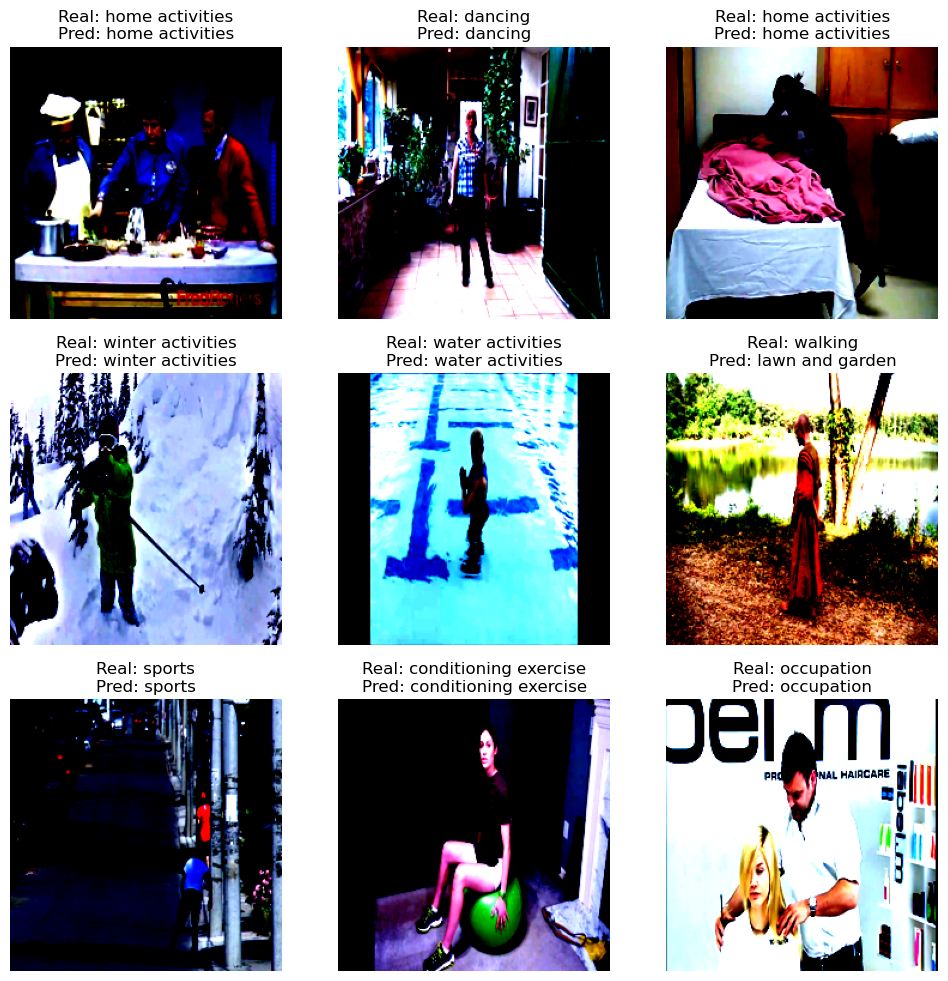

In [60]:
visualize_predictions(images, labels, ensemble_predictions, id_to_category)

In [61]:
test_images_path = "../data/img_test"

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

test_image_files = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

results = []

model_1 = model_res
model_2 = model_res_m

for image_file in test_image_files:
    image_path = os.path.join(test_images_path, image_file)
    image = Image.open(image_path).convert("RGB") 
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        probs_1 = F.softmax(model_1(image), dim=1)
        probs_2 = F.softmax(model_2(image), dim=1)
        ensemble_probs = (probs_1 + probs_2) / 2

        # Находим класс с максимальной вероятностью
        predicted_class = torch.argmax(ensemble_probs, dim=1).item()

    image_id = os.path.splitext(image_file)[0]
    results.append({"id": image_id, "target_feature": predicted_class})

submission_df = pd.DataFrame(results)

submission_file_path = "./submission.csv"
submission_df.to_csv(submission_file_path, index=False)

print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: ./submission.csv
